In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../../..")

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
from librep.datasets.har.loaders import (
    MotionSense_BalancedView20HZ
)

2022-11-01 12:36:26.988736: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-01 12:36:26.988759: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
from librep.transforms.topo_ae import TopologicalDimensionalityReduction
from librep.transforms import UMAP
from sklearn.manifold import TSNE
from experiments.Topological_ae.Experiment_utils import *

In [6]:
# MotionSense Loader
loader = MotionSense_BalancedView20HZ(
    root_dir="../../../data/views/MotionSense/balanced_view_20Hz_with_gravity_9.81_acc_standard", 
    download=False
)

# Print the readme (optional)
loader.print_readme()

# Balanced MotionSense View Resampled to 20Hz with Gravity - Multiplied acc by 9.81m/s²

This is a view from [MotionSense] that was spllited into 3s windows and was resampled to 20Hz using the [FFT method](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.resample.html#scipy.signal.resample). 

The data was first splitted in three sets: train, validation and test. Each one with the following proportions:
- Train: 70% of samples
- Validation: 10% of samples
- Test: 20% of samples

After splits, the datasets were balanced in relation to the activity code column, that is, each subset have the same number of activitiy samples.

**NOTE**: Each subset contain samples from distinct users, that is, samples of one user belongs exclusivelly to one of three subsets.

## Activity codes
- 0: downstairs (569 train, 101 validation, 170 test) 
- 1: upstairs (569 train, 101 validation, 170 test) 
- 2: sitting (569 train, 101 validation, 170 test) 
- 3: standing (569 train, 101 validation, 170 test) 
- 4: walking (569 train, 101 validation, 170 test) 
- 5: jogging (569 train, 101 validation, 170 test) 
 

## Standartized activity codes
- 0: sit (569 train, 101 validation, 170 test) 
- 1: stand (569 train, 101 validation, 170 test) 
- 2: walk (569 train, 101 validation, 170 test) 
- 3: stair up (569 train, 101 validation, 170 test) 
- 4: stair down (569 train, 101 validation, 170 test) 
- 5: run (569 train, 101 validation, 170 test) 
      




In [7]:
# Load the dataset
# If concat_train_validation is true, return a tuple (train+validation, test)
train_val, test = loader.load(concat_train_validation=True, label=loader.standard_label)
train_val, test

(PandasMultiModalDataset: samples=4020, features=360, no. window=6, label_columns='standard activity code',
 PandasMultiModalDataset: samples=1020, features=360, no. window=6, label_columns='standard activity code')

In [8]:
train_HD = np.array(train_val[:][0])
train_Y = np.array(train_val[:][1])
test_HD = np.array(test[:][0])
test_Y = np.array(test[:][1])

In [9]:
print(train_HD.shape, train_Y.shape, test_HD.shape, test_Y.shape)

(4020, 360) (4020,) (1020, 360) (1020,)


# Visualization helper

In [10]:
# 0: sit (569 train, 101 validation, 170 test)
# 1: stand (569 train, 101 validation, 170 test)
# 2: walk (569 train, 101 validation, 170 test)
# 3: stair up (569 train, 101 validation, 170 test)
# 4: stair down (569 train, 101 validation, 170 test)
# 5: run (569 train, 101 validation, 170 test)
def visualize(X, Y):
    labels = ['sit', 'stand', 'walk', 'stair up', 'stair down', 'run']
    df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=Y))
    groups = df.groupby('label')
    fig, ax = plt.subplots()
    ax.margins(0.05)
    for name, group in groups:
        ax.plot(group.x, group.y, marker='.', linestyle='', ms=8, label=labels[name])
    ax.legend()
    plt.show()

# Computing Accuracy and F1 values over high dimensionality

In [11]:
experiments_result = run_experiments(None, train_HD, train_Y, None, test_HD, test_Y)
experiments_result

{'RF-ACC': 0.798921568627451,
 'RF-F1': 0.7922558619435965,
 'SVC-ACC': 0.7745098039215687,
 'SVC-F1': 0.7778885639401502,
 'KNN-ACC': 0.5627450980392157,
 'KNN-F1': 0.5748433950949942}

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


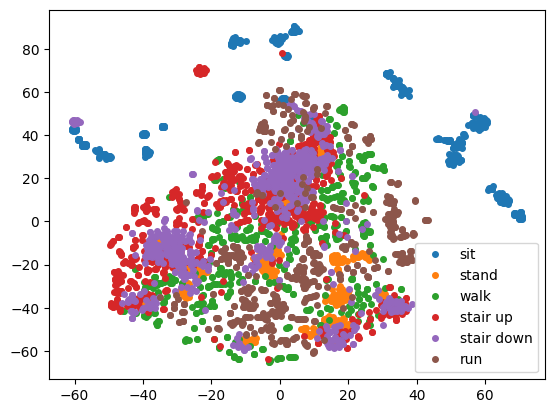

In [12]:
# Visualizing train
tsne = TSNE()
train_2D = tsne.fit_transform(train_HD)
visualize(train_2D, train_Y)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


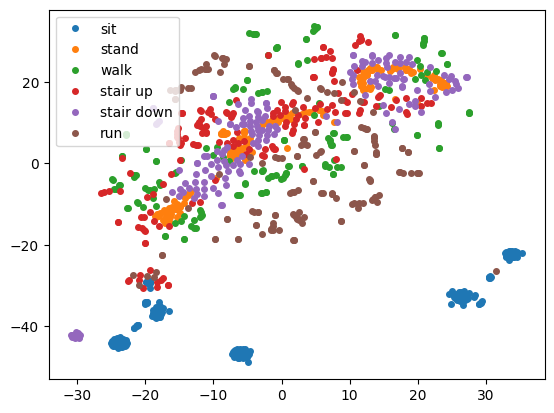

In [13]:
# Visualizing test
tsne = TSNE()
test_2D = tsne.fit_transform(test_HD)
visualize(test_2D, test_Y)

# Reducing with Generic Autoencoders

In [14]:
model_lam = 0
model_dim = 10
model_epc = 175
topo_reducer = TopologicalDimensionalityReduction(
    ae_model='DeepAE_custom_dim',
    lam = model_lam,
    ae_kwargs = {'input_dims':(1, 360), 'custom_dim':model_dim},
    input_shape = (-1, 1, 360),
    patience = None,
    num_epochs = model_epc
)

Topologically Regularized DeepAE_custom_dim
Using python to compute signatures
DeepAE_custom_dim, Input: (1, 360) Inner dim: 10


Epoch:1, P:None, Loss:23.0086, Loss-ae:23.0086, Loss-topo:4.7940
Epoch:2, P:None, Loss:23.3313, Loss-ae:23.3313, Loss-topo:8.8385
Epoch:3, P:None, Loss:22.5297, Loss-ae:22.5297, Loss-topo:8.3769
Epoch:4, P:None, Loss:22.8751, Loss-ae:22.8751, Loss-topo:10.0483
Epoch:5, P:None, Loss:22.3856, Loss-ae:22.3856, Loss-topo:9.8061
Epoch:6, P:None, Loss:22.4987, Loss-ae:22.4987, Loss-topo:10.2825
Epoch:7, P:None, Loss:22.3448, Loss-ae:22.3448, Loss-topo:10.9356
Epoch:8, P:None, Loss:22.1667, Loss-ae:22.1667, Loss-topo:11.8752
Epoch:9, P:None, Loss:22.5222, Loss-ae:22.5222, Loss-topo:15.3946
Epoch:10, P:None, Loss:22.2773, Loss-ae:22.2773, Loss-topo:19.6649
Epoch:11, P:None, Loss:22.4755, Loss-ae:22.4755, Loss-topo:15.8620
Epoch:12, P:None, Loss:22.3712, Loss-ae:22.3712, Loss-topo:20.3355
Epoch:13, P:None, Loss:22.3035, Loss-ae:22.3035, Loss-topo:21.3814
Epoch:14, P:None, Loss:21.9147, Loss-ae:21.9147, Loss-topo:25.7516
Epoch:15, P:None, Loss:22.5956, Loss-ae:22.5956, Loss-topo:27.2350
Epoch:16

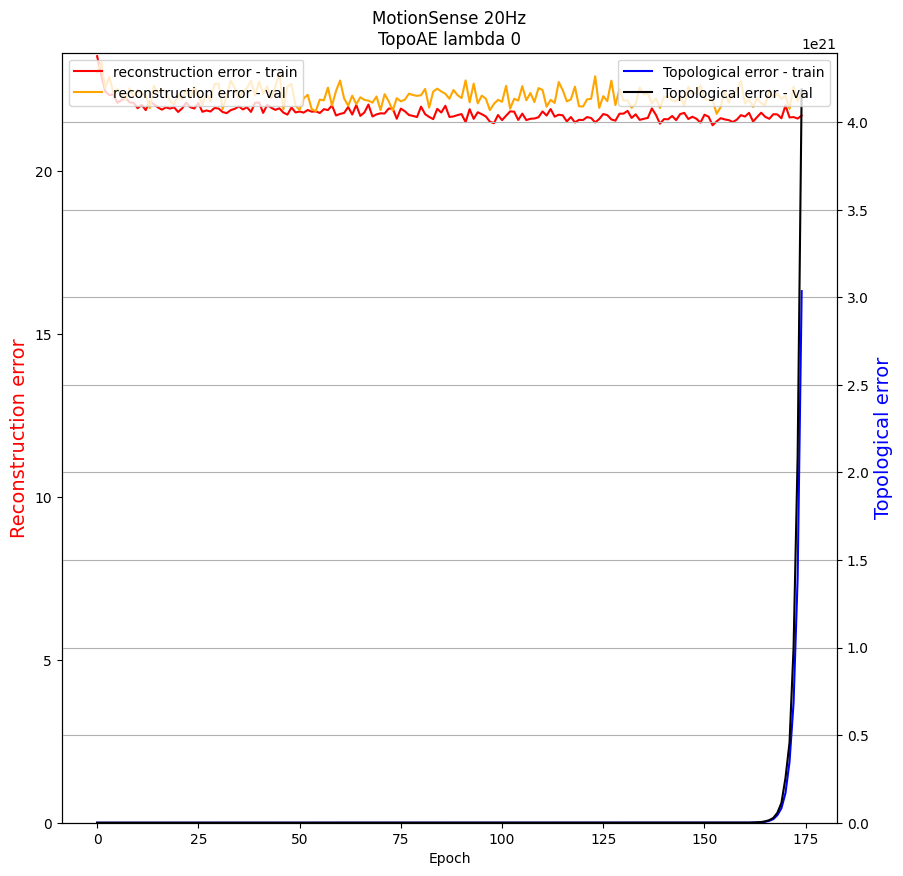

In [15]:
title_plot = "MotionSense 20Hz\nTopoAE lambda {}".format(model_lam)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [16]:
train_LD = topo_reducer.transform(train_HD)
test_LD = topo_reducer.transform(test_HD)

In [17]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (4020, 10)
TEST LD RESHAPED (1020, 10)


In [18]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

{'RF-ACC': 0.7205882352941176,
 'RF-F1': 0.7173143691629483,
 'SVC-ACC': 0.707843137254902,
 'SVC-F1': 0.7119262326883653,
 'KNN-ACC': 0.6450980392156863,
 'KNN-F1': 0.6537107331264498}

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


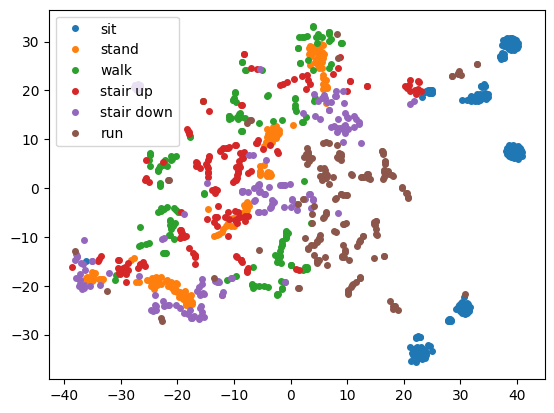

In [19]:
# Visualizing
tsne = TSNE()
test_2D = tsne.fit_transform(test_LD)
visualize(test_2D, test_Y)

# Reducing with Topological Autoencoders (L=1)

In [20]:
model_lam = 1
model_dim = 10
model_epc = 175
topo_reducer = TopologicalDimensionalityReduction(
    ae_model='DeepAE_custom_dim',
    lam = model_lam,
    ae_kwargs = {'input_dims':(1, 360), 'custom_dim':model_dim},
    input_shape = (-1, 1, 360),
    patience = None,
    num_epochs = model_epc
)

Topologically Regularized DeepAE_custom_dim
Using python to compute signatures
DeepAE_custom_dim, Input: (1, 360) Inner dim: 10


Epoch:1, P:None, Loss:23.1112, Loss-ae:23.0615, Loss-topo:0.0496
Epoch:2, P:None, Loss:22.7310, Loss-ae:22.6982, Loss-topo:0.0328
Epoch:3, P:None, Loss:22.6699, Loss-ae:22.6141, Loss-topo:0.0558
Epoch:4, P:None, Loss:22.6444, Loss-ae:22.6030, Loss-topo:0.0414
Epoch:5, P:None, Loss:22.5113, Loss-ae:22.4905, Loss-topo:0.0209
Epoch:6, P:None, Loss:22.3034, Loss-ae:22.2956, Loss-topo:0.0078
Epoch:7, P:None, Loss:22.7192, Loss-ae:22.7086, Loss-topo:0.0106
Epoch:8, P:None, Loss:22.8124, Loss-ae:22.6097, Loss-topo:0.2027
Epoch:9, P:None, Loss:22.7818, Loss-ae:22.7648, Loss-topo:0.0170
Epoch:10, P:None, Loss:22.7427, Loss-ae:22.7393, Loss-topo:0.0034
Epoch:11, P:None, Loss:22.6923, Loss-ae:22.6825, Loss-topo:0.0098
Epoch:12, P:None, Loss:23.4333, Loss-ae:23.4179, Loss-topo:0.0154
Epoch:13, P:None, Loss:22.6094, Loss-ae:22.6027, Loss-topo:0.0067
Epoch:14, P:None, Loss:22.1460, Loss-ae:22.1416, Loss-topo:0.0045
Epoch:15, P:None, Loss:23.2478, Loss-ae:23.2414, Loss-topo:0.0063
Epoch:16, P:None, L

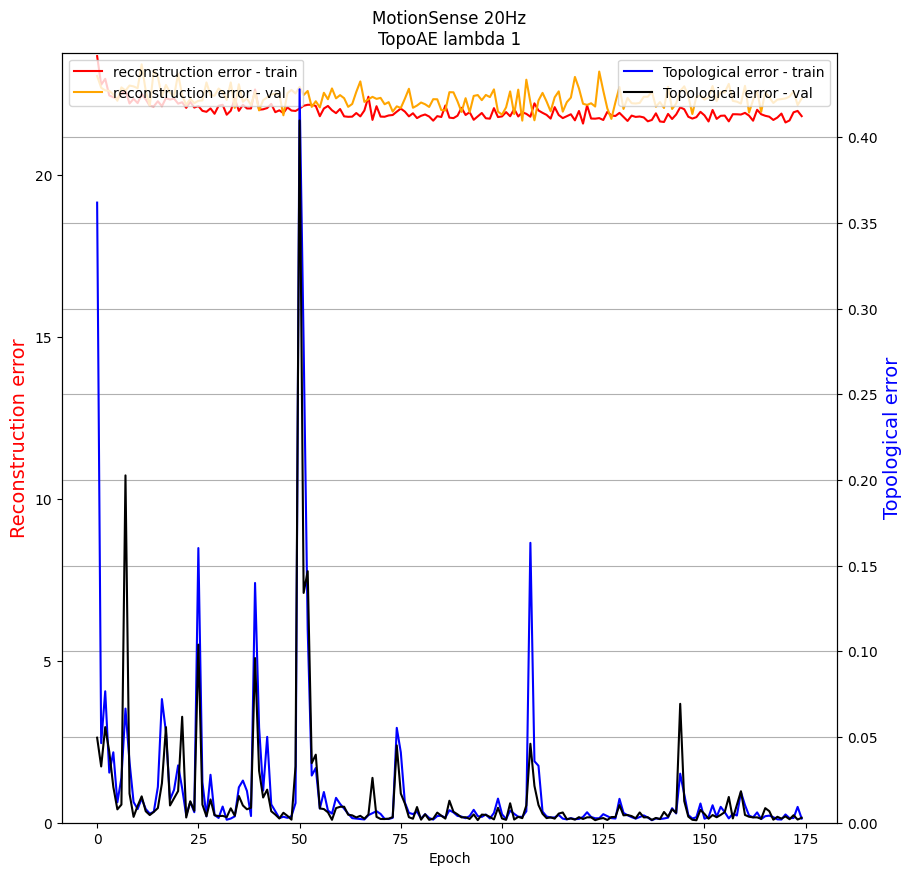

In [21]:
title_plot = "MotionSense 20Hz\nTopoAE lambda {}".format(model_lam)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [22]:
train_LD = topo_reducer.transform(train_HD)
test_LD = topo_reducer.transform(test_HD)

In [23]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (4020, 10)
TEST LD RESHAPED (1020, 10)


In [24]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

{'RF-ACC': 0.6654901960784314,
 'RF-F1': 0.6571354688093642,
 'SVC-ACC': 0.6686274509803921,
 'SVC-F1': 0.6729185738909387,
 'KNN-ACC': 0.6049019607843137,
 'KNN-F1': 0.6095660727363963}

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


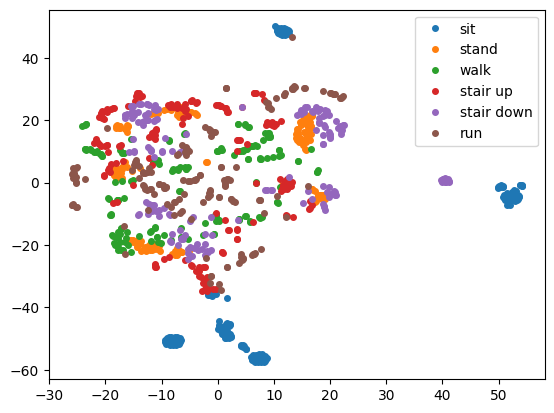

In [25]:
# Visualizing
tsne = TSNE()
test_2D = tsne.fit_transform(test_LD)
visualize(test_2D, test_Y)

# Reducing with Topological Autoencoders (L=10)

In [26]:
model_lam = 10
model_dim = 10
model_epc = 175
topo_reducer = TopologicalDimensionalityReduction(
    ae_model='DeepAE_custom_dim',
    lam = model_lam,
    ae_kwargs = {'input_dims':(1, 360), 'custom_dim':model_dim},
    input_shape = (-1, 1, 360),
    patience = None,
    num_epochs = model_epc
)

Topologically Regularized DeepAE_custom_dim
Using python to compute signatures
DeepAE_custom_dim, Input: (1, 360) Inner dim: 10


Epoch:1, P:None, Loss:23.4323, Loss-ae:23.2638, Loss-topo:0.0169
Epoch:2, P:None, Loss:22.6253, Loss-ae:22.5831, Loss-topo:0.0042
Epoch:3, P:None, Loss:22.3707, Loss-ae:22.3190, Loss-topo:0.0052
Epoch:4, P:None, Loss:22.7836, Loss-ae:22.7391, Loss-topo:0.0044
Epoch:5, P:None, Loss:22.9722, Loss-ae:22.7882, Loss-topo:0.0184
Epoch:6, P:None, Loss:22.9615, Loss-ae:22.9398, Loss-topo:0.0022
Epoch:7, P:None, Loss:22.7680, Loss-ae:22.7010, Loss-topo:0.0067
Epoch:8, P:None, Loss:23.1962, Loss-ae:23.1263, Loss-topo:0.0070
Epoch:9, P:None, Loss:23.4232, Loss-ae:23.0054, Loss-topo:0.0418
Epoch:10, P:None, Loss:22.6701, Loss-ae:22.6065, Loss-topo:0.0064
Epoch:11, P:None, Loss:22.2674, Loss-ae:22.2388, Loss-topo:0.0029
Epoch:12, P:None, Loss:22.6568, Loss-ae:22.6315, Loss-topo:0.0025
Epoch:13, P:None, Loss:22.8707, Loss-ae:22.5565, Loss-topo:0.0314
Epoch:14, P:None, Loss:22.9443, Loss-ae:22.8973, Loss-topo:0.0047
Epoch:15, P:None, Loss:22.5378, Loss-ae:22.5034, Loss-topo:0.0034
Epoch:16, P:None, L

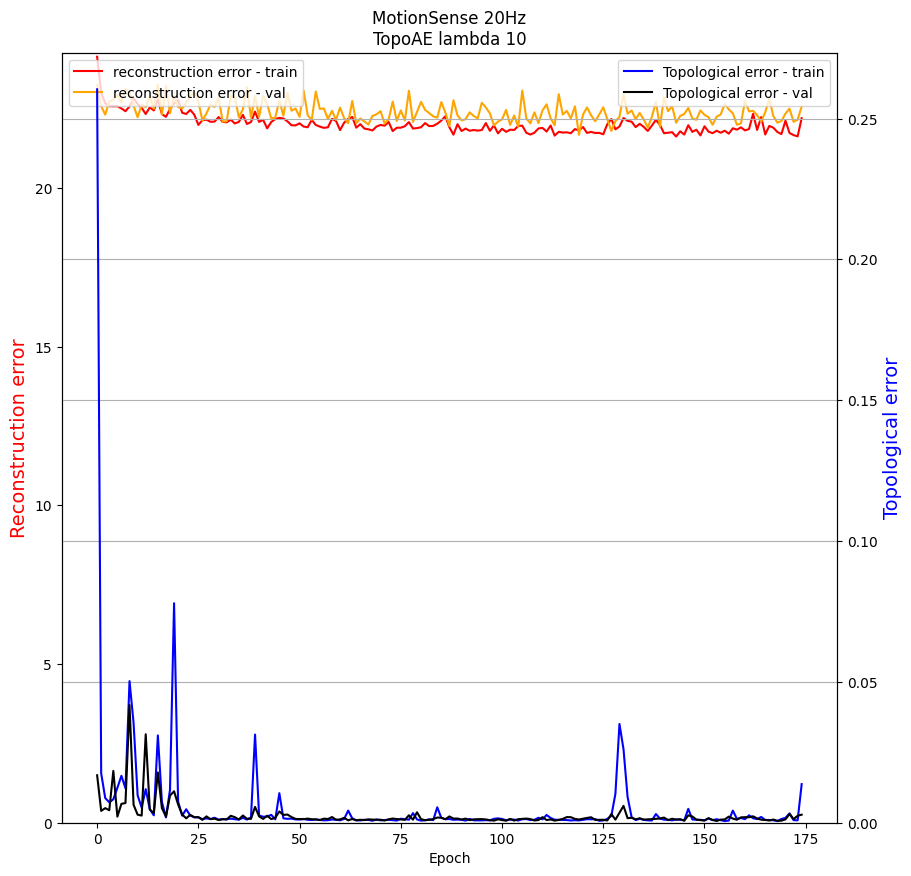

In [27]:
title_plot = "MotionSense 20Hz\nTopoAE lambda {}".format(model_lam)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [28]:
train_LD = topo_reducer.transform(train_HD)
test_LD = topo_reducer.transform(test_HD)

In [29]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (4020, 10)
TEST LD RESHAPED (1020, 10)


In [30]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

{'RF-ACC': 0.5780392156862744,
 'RF-F1': 0.5732766533247486,
 'SVC-ACC': 0.6323529411764706,
 'SVC-F1': 0.6362861678335657,
 'KNN-ACC': 0.5647058823529412,
 'KNN-F1': 0.5706277579051515}

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


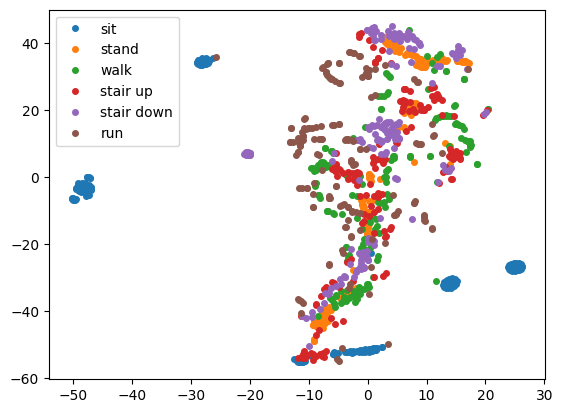

In [31]:
# Visualizing
tsne = TSNE()
test_2D = tsne.fit_transform(test_LD)
visualize(test_2D, test_Y)

# Reducing with Topological Autoencoders (L=100)

In [32]:
model_lam = 100
model_dim = 10
model_epc = 175
topo_reducer = TopologicalDimensionalityReduction(
    ae_model='DeepAE_custom_dim',
    lam = model_lam,
    ae_kwargs = {'input_dims':(1, 360), 'custom_dim':model_dim},
    input_shape = (-1, 1, 360),
    patience = None,
    num_epochs = model_epc
)

Topologically Regularized DeepAE_custom_dim
Using python to compute signatures
DeepAE_custom_dim, Input: (1, 360) Inner dim: 10


Epoch:1, P:None, Loss:25.6873, Loss-ae:24.0466, Loss-topo:0.0164
Epoch:2, P:None, Loss:23.7323, Loss-ae:23.4164, Loss-topo:0.0032
Epoch:3, P:None, Loss:23.3769, Loss-ae:23.1592, Loss-topo:0.0022
Epoch:4, P:None, Loss:23.4432, Loss-ae:23.0271, Loss-topo:0.0042
Epoch:5, P:None, Loss:24.0022, Loss-ae:23.5800, Loss-topo:0.0042
Epoch:6, P:None, Loss:23.6408, Loss-ae:23.4285, Loss-topo:0.0021
Epoch:7, P:None, Loss:23.2065, Loss-ae:22.9880, Loss-topo:0.0022
Epoch:8, P:None, Loss:23.2653, Loss-ae:22.9268, Loss-topo:0.0034
Epoch:9, P:None, Loss:27.4526, Loss-ae:23.6608, Loss-topo:0.0379
Epoch:10, P:None, Loss:23.5893, Loss-ae:23.1759, Loss-topo:0.0041
Epoch:11, P:None, Loss:23.1809, Loss-ae:22.6305, Loss-topo:0.0055
Epoch:12, P:None, Loss:22.9696, Loss-ae:22.6726, Loss-topo:0.0030
Epoch:13, P:None, Loss:23.3671, Loss-ae:22.9969, Loss-topo:0.0037
Epoch:14, P:None, Loss:23.3898, Loss-ae:23.1303, Loss-topo:0.0026
Epoch:15, P:None, Loss:22.9539, Loss-ae:22.8157, Loss-topo:0.0014
Epoch:16, P:None, L

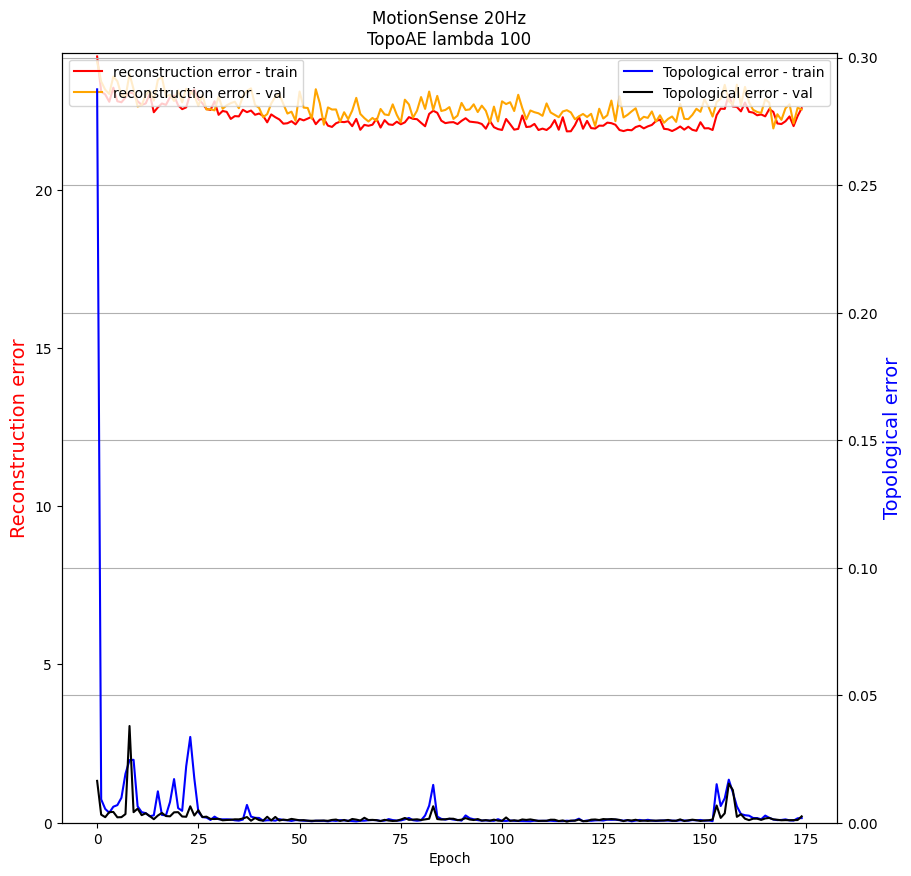

In [33]:
title_plot = "MotionSense 20Hz\nTopoAE lambda {}".format(model_lam)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [34]:
train_LD = topo_reducer.transform(train_HD)
test_LD = topo_reducer.transform(test_HD)

In [35]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (4020, 10)
TEST LD RESHAPED (1020, 10)


In [36]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

{'RF-ACC': 0.6100000000000001,
 'RF-F1': 0.5986564023514271,
 'SVC-ACC': 0.5617647058823529,
 'SVC-F1': 0.5633303646729146,
 'KNN-ACC': 0.5735294117647058,
 'KNN-F1': 0.581076303171507}

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


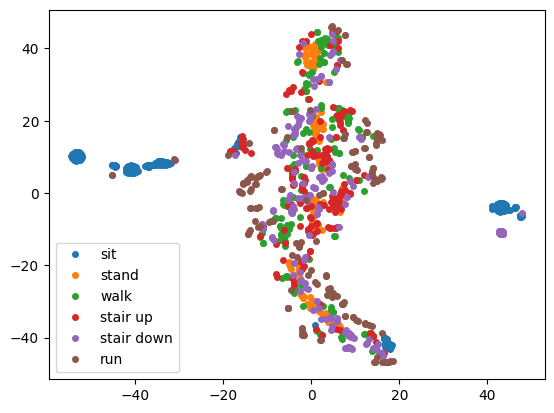

In [37]:
# Visualizing
tsne = TSNE()
test_2D = tsne.fit_transform(test_LD)
visualize(test_2D, test_Y)

In [38]:
# Reducing with Convolutional Topological Autoencoders

In [39]:
# model_lam = 1
# model_dim = 10
# model_epc = 200
# topo_reducer = TopologicalDimensionalityReduction(
#     ae_model='ConvolutionalAutoencoder_custom_dim',
#     lam = model_lam,
#     ae_kwargs = {'input_dims':(1, 360), 'custom_dim':model_dim},
#     input_shape = (-1, 1, 1, 360),
#     patience = None,
#     num_epochs = model_epc
# )

In [40]:
# title_plot = "MotionSense 20Hz\nTopoAE lambda {}".format(model_lam)
# topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [41]:
# train_LD = topo_reducer.transform(train_HD)
# test_LD = topo_reducer.transform(test_HD)

In [42]:
# train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
# print('TRAIN LD RESHAPED', train_LD.shape)
# test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
# print('TEST LD RESHAPED', test_LD.shape)

In [43]:
# experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
# experiments_result

# Reducing with UMAP

In [44]:
umap_reducer = UMAP(n_components=model_dim)
umap_reducer.fit(train_HD, train_Y)

UMAP(n_components=10, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [45]:
train_LD = umap_reducer.transform(train_HD)
test_LD = umap_reducer.transform(test_HD)

In [46]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (4020, 10)
TEST LD RESHAPED (1020, 10)


In [47]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

{'RF-ACC': 0.6079411764705883,
 'RF-F1': 0.5971524036524679,
 'SVC-ACC': 0.5617647058823529,
 'SVC-F1': 0.5633303646729146,
 'KNN-ACC': 0.5735294117647058,
 'KNN-F1': 0.581076303171507}

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


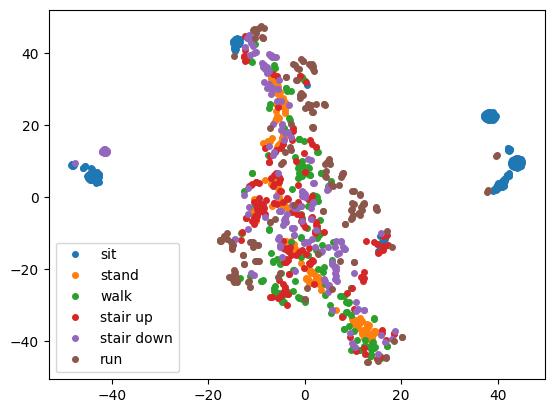

In [48]:
# Visualizing
tsne = TSNE()
test_2D = tsne.fit_transform(test_LD)
visualize(test_2D, test_Y)